In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic-machine-learning-from-disaster/train.csv
/kaggle/input/titanic-machine-learning-from-disaster/test.csv


# 1. IMPORTING LIBRARIES

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib import style
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

# 2. IMPORTING DATASET

In [3]:
train_df=pd.read_csv("/kaggle/input/titanic-machine-learning-from-disaster/train.csv")
test_df=pd.read_csv("/kaggle/input/titanic-machine-learning-from-disaster/test.csv")

# 3. EXPLORATORY ANALYSIS

In [4]:
count = train_df.isnull().sum().sort_values(ascending=False)
percent_train = train_df.isnull().sum()/train_df.isnull().count()*100
percent_test = (round(percent_train, 1)).sort_values(ascending=False)
missing_data = pd.concat([count, percent_test], axis=1, keys=['Count', '%'])
missing_data.head(5)

,Count,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
Fare,0,0.0
Ticket,0,0.0


The Embarked feature has 2 missing values , while age feature has 177 missing values and cabin feature has 687 missing values. So we can drop cabin feature as it contains 77% missing values from dataset. But before dropping any feature we will first check which feature contributes to survival rate of passenger

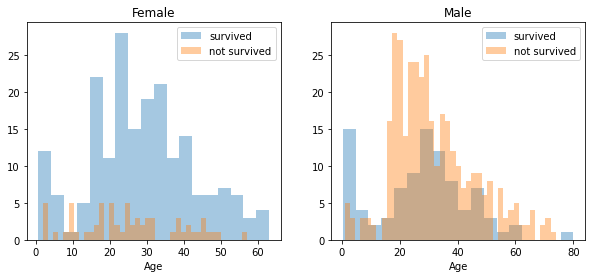

In [5]:
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
women = train_df[train_df['Sex']=='female']
men = train_df[train_df['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False)
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False)
ax.legend()
_ = ax.set_title('Male')

You can see that men have a high probability of survival when they are between 19 and 33 years old, which is also a little bit true for women but not fully. For women the survival chances are higher between 15 and 42.For men the probability of survival is very low between the age of 7 and 19, but that isn’t true for women. Another thing to note is that infants also have a little bit higher probability of survival.

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


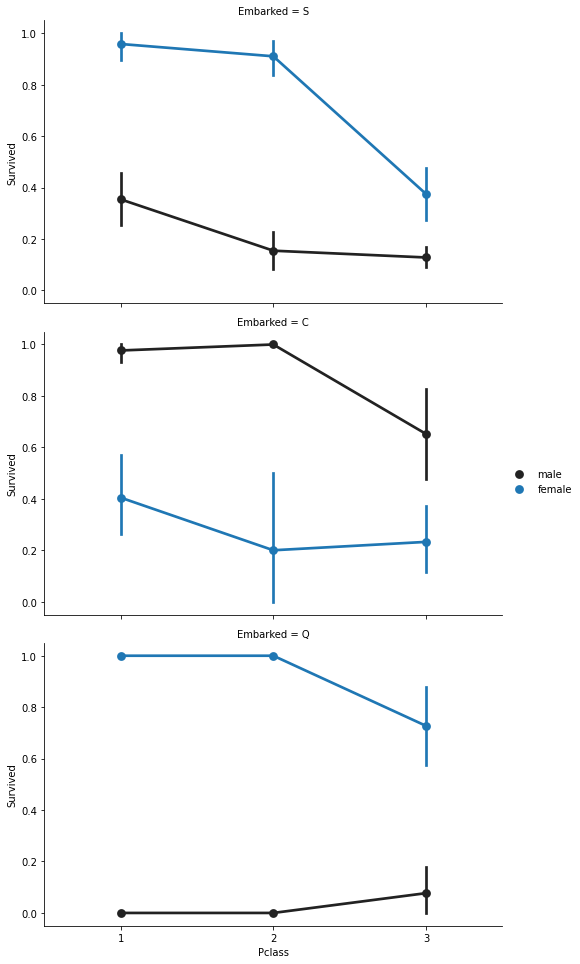

In [6]:
FacetGrid = sns.FacetGrid(train_df, row='Embarked', size=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette=None,  order=None, hue_order=None )
FacetGrid.add_legend()

Embarked seems to be correlated with survival, depending on the gender.Women on port Q and on port S have a higher chance of survival. The inverse is true, if they are at port C. Men have a high survival probability if they are on port C, but a low probability if they are on port Q or S. Pclass also seems to be correlated with survival.

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


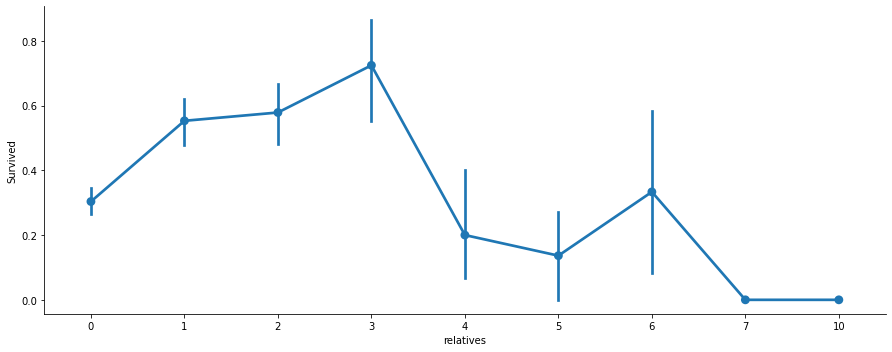

In [7]:
data = [train_df, test_df]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)
axes = sns.factorplot('relatives','Survived', 
                      data=train_df, aspect = 2.5, )

we can see that you had a high probabilty of survival with 1 to 3 realitves, but a lower one if you had less than 1 or more than 3 (except for some cases with 6 relatives).

# 4. DATA PREPROCESSING

In [8]:
## FOR AGE
data = [train_df, test_df]

for dataset in data:
    mean = train_df["Age"].mean()
    std = test_df["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = train_df["Age"].astype(int)
print("null values for AGE feature = ",train_df["Age"].isnull().sum())


null values for AGE feature =  0


In [9]:
## FOR EMBARKED
train_df['Embarked'].describe()
common_value = 'S'
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)
print("null values for EMBARKED feature = ",train_df["Embarked"].isnull().sum())

null values for EMBARKED feature =  0


# 5. CONVERTING FEATURES

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    int64  
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
 12  relatives    891 non-null    int64  
 13  not_alone    891 non-null    int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 97.6+ KB


In [11]:
## for FARE
for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

In [12]:
## for NAME
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    # filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna(0)
train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)

In [13]:
## for SEX
genders = {"male": 0, "female": 1}
data = [train_df, test_df]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

we cant see any use of ticket info related to survival rate so we drop this column

In [14]:
train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)

In [15]:
## for EMBARKED
data = [train_df, test_df]
ports = {"S": 0, "C": 1, "Q": 2}
for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

In [16]:
## for AGE
data = [train_df, test_df]
for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6
train_df['Age'].value_counts()

4    160
6    158
3    146
5    145
2    118
1     96
0     68
Name: Age, dtype: int64

In [17]:
## for CABIN
import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train_df, test_df]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)# we can now drop the cabin feature
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)

In [18]:
## for FARE
data = [train_df, test_df]

for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)

# 6. BUILDING MODELS 

In [19]:
X_train = train_df.drop(["Survived","PassengerId"], axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()

In [20]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,not_alone,Title,Deck
0,3,0,2,1,0,0,0,1,0,1,8
1,1,1,5,1,0,3,1,1,0,3,3
2,3,1,3,0,0,0,0,0,1,2,8
3,1,1,5,1,0,3,0,1,0,3,3
4,3,0,5,0,0,1,0,0,1,1,8


In [21]:
X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,not_alone,Title,Deck
0,3,0,2,0,0,0,2,0,1,1,8
1,3,1,5,1,0,0,0,1,0,3,8
2,2,0,3,0,0,1,2,0,1,1,8
3,3,0,5,0,0,1,0,0,1,1,8
4,3,1,5,1,1,1,0,2,0,3,8


In [22]:
#STOCHASTIC GRADIENT DESCENT
sgd = linear_model.SGDClassifier(max_iter=5, tol=None)
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
sgd.score(X_train, Y_train)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)

#RANDOM FOREST
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_prediction = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)

#LOGISTIC REGRESSION
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)

#KNN
knn = KNeighborsClassifier(n_neighbors = 3) 
knn.fit(X_train, Y_train)  
Y_pred = knn.predict(X_test)  
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)

#GAUSSIAN NAIVE BAYES
gaussian = GaussianNB() 
gaussian.fit(X_train, Y_train)  
Y_pred = gaussian.predict(X_test)  
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)

#PERCEPTRON
perceptron = Perceptron(max_iter=5)
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)

#LINEAR SUPPORT VECTOR MACHINE
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)

#DECISION TREE
decision_tree = DecisionTreeClassifier() 
decision_tree.fit(X_train, Y_train)  
Y_pred = decision_tree.predict(X_test)  
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


# 7. CHECKING WHICH IS BEST MODEL

In [23]:
results = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 
              'Decision Tree'],
    'Score': [acc_linear_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_decision_tree]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df.head(9)

,Model
Score,
92.82,Random Forest
92.82,Decision Tree
86.53,KNN
81.48,Support Vector Machines
81.48,Logistic Regression
81.03,Perceptron
78.45,Naive Bayes
78.11,Stochastic Gradient Decent


# AS WE CAN SEE RANDOM FOREST APPEARS ON THE TOP SO WE GO AHEAD WITH RANDOM FOREST

In [24]:
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rf, X_train, Y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.77777778 0.85393258 0.74157303 0.85393258 0.87640449 0.86516854
 0.7752809  0.79775281 0.86516854 0.83146067]
Mean: 0.8238451935081148
Standard Deviation: 0.04469500414133787


OUR MODEL HAS ACCURACY AVERAGE OF 82%. SINCE OUR STANDARD DEVIATION IS AROUND 4% THAT MEANS WE CAN STILL TRY FURTHER TO IMPROVE OUR ACCURACY

# FEATURE IMPORTANCE

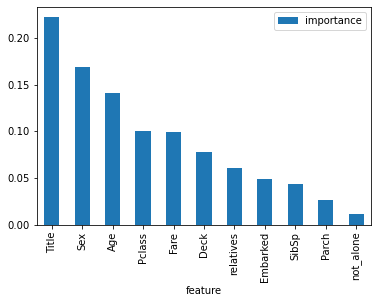

In [25]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()

not_alone and Parch doesn’t play a significant role in our random forest classifiers prediction process. Because of that I will drop them and check accuracy of classifier again

In [26]:
train_df  = train_df.drop("not_alone", axis=1)
test_df  = test_df.drop("not_alone", axis=1)

train_df  = train_df.drop("Parch", axis=1)
test_df  = test_df.drop("Parch", axis=1)

In [27]:
random_forest = RandomForestClassifier(n_estimators=100, oob_score = True)
random_forest.fit(X_train, Y_train)
Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)

acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
print(round(acc_random_forest,2,), "%")

92.82 %


AS YOU CAN SEE WE GOT ACCURACY OF 92.82%, WE WILL STILL TRY TO SEE WHETHER IT GOES AHEAD

In [28]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
predictions = cross_val_predict(random_forest, X_train, Y_train, cv=3)
confusion_matrix(Y_train, predictions)

array([[478,  71],
       [103, 239]])

492 passengers were correctly classified as not survived (called true negatives) and 57 where wrongly classified as not survived (false positives).
95 passengers where wrongly classified as survived (false negatives) and 247 where correctly classified as survived (true positives).

now we will check f score which is combination of our precision and recall and we will plot both graphs

In [29]:
from sklearn.metrics import f1_score
f1_score(Y_train, predictions)

0.7331288343558282

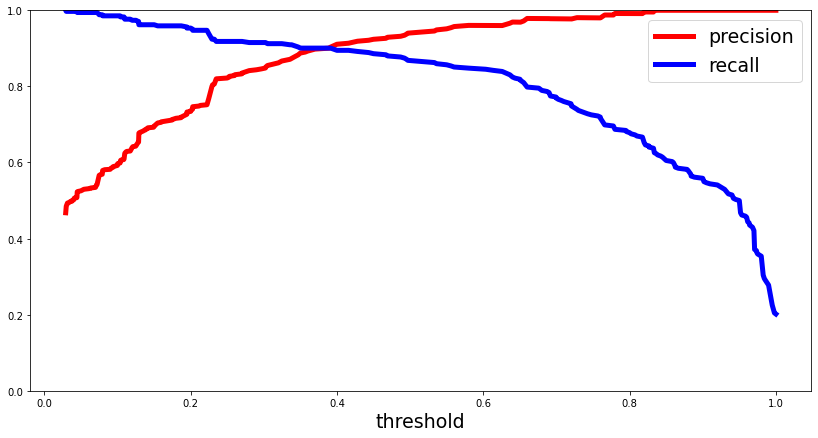

In [30]:
from sklearn.metrics import precision_recall_curve

# getting the probabilities of our predictions
y_scores = random_forest.predict_proba(X_train)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(Y_train, y_scores)
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

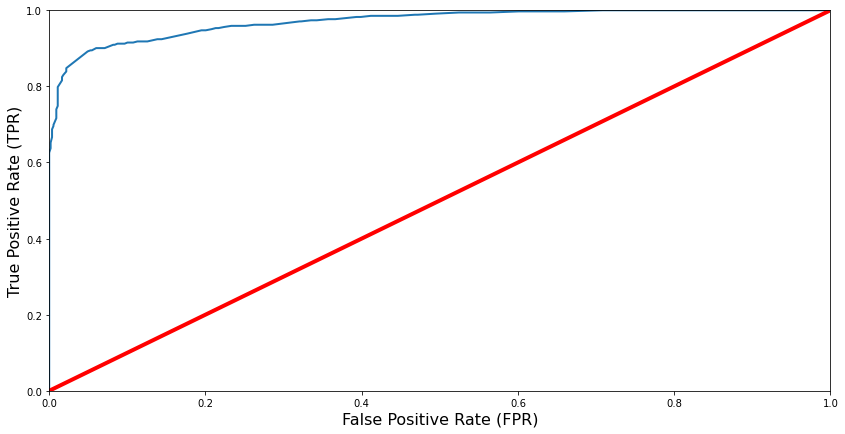

In [31]:
from sklearn.metrics import roc_curve
# compute true positive rate and false positive rate
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_train, y_scores)# plotting them against each other
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

now we will check ROC AUC SCORE i.e. accuracy of our model

In [32]:
from sklearn.metrics import roc_auc_score
r_a_score = roc_auc_score(Y_train, y_scores)
print("ROC-AUC-Score:", r_a_score)

ROC-AUC-Score: 0.9703820875808221
